# **CRIAÇÃO DE MODELO DE CLASSIFICAÇÃO SUPERVISIONADO PARA ANÁLISE DE FAKE NEWS.**

In [1]:
# importar o arquivo diretamente de seu google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Pacotes utilizados
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#criando uma copia do dataframe na minha pasta drive
!cp /content/drive/MyDrive/pre-processed.csv /content

In [4]:
#criando o DataFrame
df = pd.read_csv("pre-processed.csv",header=0, encoding="UTF-8")
df.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [5]:
# Removendo a coluna index
df.drop('index', axis=1, inplace=True)

In [6]:
#Funcao para truncar o texto, deixando com a quantidade de palavras iguais(aproximadamente)
def truncate_text(text, max_length):
    tokens = word_tokenize(text)  # Tokeniza o texto em palavras
    truncated_tokens = tokens[:max_length]  # Seleciona os primeiros 'max_length' tokens
    truncated_text = ' '.join(truncated_tokens)  # Junta os tokens em um texto truncado
    return truncated_text

In [7]:
#Crianda uma coluna para o texto truncado
df['texto_truncado'] = df['preprocessed_news'].apply(lambda x: truncate_text(x, 75))

In [103]:
# Criando as variaveis para ser treinadas
X = df['texto_truncado']
y = df['label']

In [104]:
#dividindo o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [105]:
#Transformando para TD-IDF para treinar o modelo
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [106]:
#criando o modelo
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [107]:
# Fazer previsões
y_pred = model.predict(X_test_tfidf)

# Calcular a precisão
accuracy = accuracy_score(y_test, y_pred)
print("Precisão do modelo: {:.2f}%".format(accuracy * 100))

Precisão do modelo: 89.06%


# **Criando a nuvem de palavras**

In [135]:
#Combinando os dados de treino e teste para criação da nuvem de palavras
concat_df = pd.concat([y_train, X_train], axis=1)

In [136]:
concat_df

,label,texto_truncado
1699,fake,senador magno malta pronuncia sobre pastor abu...
840,fake,chico xavier previu terceira guerra mundial de...
599,fake,arrogancia machismo prepotencia reinaldo azeve...
1272,fake,diz honesto todos funcionarios mp policia fede...
5855,true,ilha europa muda cada seis meses localizada fr...
...,...,...
1180,fake,nao sao conheca gangue cachorros uniu destruir...
3441,fake,apresentador record sofreu aneurisma vivo oper...
1344,fake,temer comete erro principiante twitter reconhe...
4623,true,novo processo criminal aberto nesta juiz feder...


In [137]:
#ordenando pelo tipo de label, resetando e dropando a coluna index
df_treino = concat_df.sort_values('label').reset_index().drop('index', axis=1)

In [138]:
df_treino

,label,texto_truncado
0,fake,senador magno malta pronuncia sobre pastor abu...
1,fake,lula defende ditador sanguinario siria diz tru...
2,fake,atitude lula confirma diagnostico transtorno i...
3,fake,nove senadores gastam r milhao reformar aposen...
4,fake,cunha rebate criticas dilma mentirosa arrogant...
...,...,...
5395,true,planalto pode apoiar eleicao alckmin afirma ma...
5396,true,vamos lembrar meditacoes vii john donne nenhum...
5397,true,corpo atriz tonia carrero sera cremado nesta v...
5398,true,tse revoga prisao garotinho corte decidiu rio ...


In [123]:
#Separando o fake do real
df_treino_f = df_treino['texto_truncado'][:2700]
df_treino_r = df_treino['texto_truncado'][2700:]

In [124]:
#List comprehension para dividir o texto em palavras
num_f = [palavra for texto in df_treino_f for palavra in texto.split()]
num_r = [palavra for texto in df_treino_r for palavra in texto.split()]

In [125]:
#Total de texto fake e real
print(f'Numeros de palavras fake: {len(num_f)} , Numero de palavras real: {len(num_r)}')

Numeros de palavras fake: 185022 , Numero de palavras real: 202341


In [126]:
#aplicando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_fake = vectorizer.fit_transform([tokens for tokens in num_f])
tfidf_real = vectorizer.fit_transform([tokens for tokens in num_r])

In [127]:
# Criação das nuvens de palavras para "fake"
palavras_fake = vectorizer.get_feature_names_out() 
tfidf_scores_fake = tfidf_fake.toarray().sum(axis=0)
nuvem_palavras_fake = WordCloud().generate_from_frequencies(dict(zip(palavras_fake, tfidf_scores_fake)))


In [128]:
# Criação das nuvens de palavras para "real"
palavras_real = vectorizer.get_feature_names_out() 
tfidf_scores_real = tfidf_real.toarray().sum(axis=0)
nuvem_palavras_real = WordCloud().generate_from_frequencies(dict(zip(palavras_real, tfidf_scores_real)))

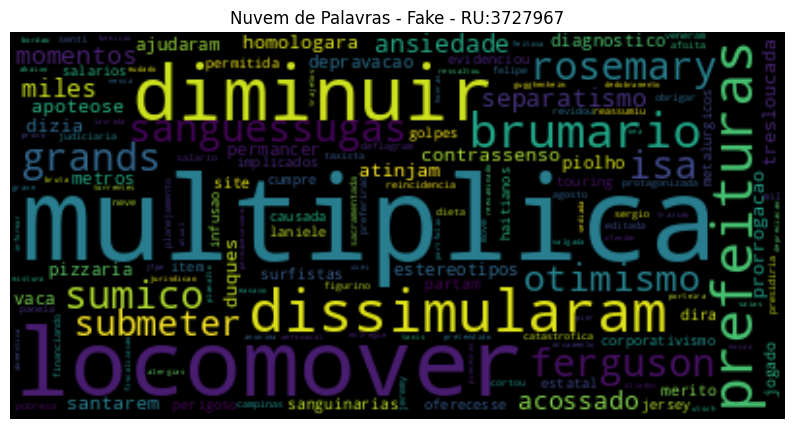

In [129]:
# Plotagem das nuvens de palavras fake
plt.figure(figsize=(10, 10))

plt.title("Nuvem de Palavras - Fake - RU:3727967")
plt.axis("off")

plt.imshow(nuvem_palavras_fake, interpolation='bilinear');

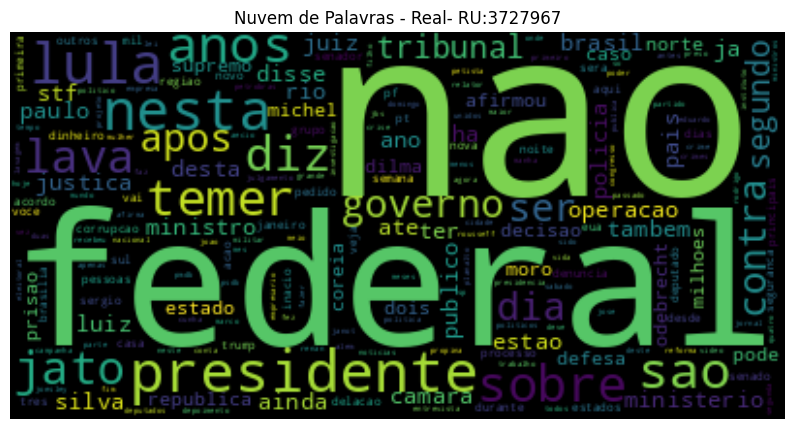

In [130]:
# Plotagem das nuvens de palavras real
plt.figure(figsize=(10, 10))

plt.title("Nuvem de Palavras - Real- RU:3727967")
plt.axis("off")

plt.imshow(nuvem_palavras_real, interpolation='bilinear');